In [2]:
import os
import pandas as pd
import numpy as np
from helpers import VolleyWrapper, aggregate_similarities_all, show_analysed_frames, adjusted_r2
import tqdm
from sklearn.linear_model import LinearRegression, Lasso
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

os.chdir('/Users/jniedziela/Developer/master/bpe/')

DATA_DIR = 'attack_pose_data/'
SCORES_DATA = 'attack_pose_data/pose_scores.xlsx'
JSON_DATA_DIR = 'attack_pose_data/json_files/'
EXCEL_DATA_DIR = 'attack_pose_data/excel_files/'

/Users/jniedziela/.pyenv/versions/3.10.0/envs/bpe_2/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
SCORE_COLUMNS = [
    'aanloop_aantal_passen_score', # NUMBER OF STEPS B4 JUMP IF > 2 THEN 1 ELSE 0 (0 or 1)
    'rem_pas_score',  # LAST STEP (0 or 1)
    'sprong_hoek_score', # JUMP ANGLE (0 to 1)
    'positie_tov_bal_score', # POSITION RELATIVE TO BALL (0 or 1)
    'slagarm_hoek_score', # ATTACK ARM ANGLE (0 to 1)
    'totaal_score'
]

scores = pd.read_excel(SCORES_DATA, index_col=0)[['pose_tabel'] + SCORE_COLUMNS]
scores['json_file'] = scores['pose_tabel'].str.replace('.xlsx', '.json')
scores.sample(5)

,pose_tabel,aanloop_aantal_passen_score,rem_pas_score,sprong_hoek_score,positie_tov_bal_score,slagarm_hoek_score,totaal_score,json_file
21,GX010045_Clip_15_POSE_tabel.xlsx,1,1,0.711111,0,0.850000,3.561111,GX010045_Clip_15_POSE_tabel.json
33,GX010046_Clip_19_POSE_tabel.xlsx,1,1,0.444444,0,0.844444,3.288889,GX010046_Clip_19_POSE_tabel.json
17,GX010044_Clip_8_POSE_tabel.xlsx,1,1,0.533333,1,0.833333,4.366667,GX010044_Clip_8_POSE_tabel.json
37,GX010046_Clip_3_POSE_tabel.xlsx,1,0,0.411111,0,0.922222,2.333333,GX010046_Clip_3_POSE_tabel.json
13,GX010044_Clip_16_POSE_tabel.xlsx,1,1,0.766667,0,0.944444,3.711111,GX010044_Clip_16_POSE_tabel.json


In [4]:
best_scored_video = scores.sort_values('slagarm_hoek_score', ascending=False).iloc[0]
display(best_scored_video)
best_scored_video_file = best_scored_video['json_file']

pose_tabel                     GX010046_Clip_21_POSE_tabel.xlsx
aanloop_aantal_passen_score                                   1
rem_pas_score                                                 1
sprong_hoek_score                                      0.477778
positie_tov_bal_score                                         0
slagarm_hoek_score                                     0.961111
totaal_score                                           3.438889
json_file                      GX010046_Clip_21_POSE_tabel.json
Name: 34, dtype: object

In [5]:
# get frame in which attack happens (ball hit)
attack_frames = {}
for file in os.listdir(EXCEL_DATA_DIR):
    df = pd.read_excel(EXCEL_DATA_DIR + file)
    attack_frames[file.replace('.xlsx', '.json')] = df[df.phase == 'attack'][1:-1].Frame.iloc[0]

In [8]:
def window_stride_grid_search_attack(window_range, stride_range, cols_to_use, y_col, num_frames):
    '''
    Function to perform grid search over window and stride values for similarity analysis.
    
    Parameters:
    window_range (range): range of window sizes to test
    stride_range (range): range of stride sizes to test
    cols_to_use (list): list of columns to use in the model as features
    y_col (str): name of the column to use as target variable
    num_frames (int): number of frames to use in the analysis (centered around the attack frame)
    
    Returns:
    search_results (DataFrame): DataFrame with results of the grid search
    '''
    AGG_COLS = ['ra_min', 'la_min', 'rl_min', 'll_min', 'torso_min', 'ra_max', 'la_max', 'rl_max', 'll_max', 'torso_max', 'ra_mean', 'la_mean', 'rl_mean', 'll_mean', 'torso_mean', 'ra_std', 'la_std', 'rl_std', 'll_std', 'torso_std']
    search_results = pd.DataFrame(columns=['window', 'stride', 'score', 'adj_r2'])

    for window in tqdm.tqdm(window_range):
        for stride in stride_range:

            results_df = pd.DataFrame(columns=['video_1', 'video_2'] + AGG_COLS)

            vid_1_path = JSON_DATA_DIR + best_scored_video_file

            for vid_2 in os.listdir(JSON_DATA_DIR):
                vid_2_path = JSON_DATA_DIR + vid_2
                analyser = VolleyWrapper(vid_1_path, vid_2_path, window, stride)

                s1_attack = attack_frames[analyser.args.vid1_json_dir.split('/')[-1]]
                analyser.seq1 = analyser.seq1[:, :, s1_attack - num_frames // 2: s1_attack + num_frames // 2]

                s2_attack = attack_frames[analyser.args.vid2_json_dir.split('/')[-1]]
                analyser.seq2 = analyser.seq2[:, :, s2_attack - num_frames // 2 : s2_attack + num_frames // 2]

                analyser._update_similarities()

                sims = analyser.motion_similarity_per_window

                sims_agg = aggregate_similarities_all(sims)

                results_df.loc[len(results_df)] = [
                    best_scored_video_file, 
                    vid_2, 
                    *list(sims_agg.values())
                    ]
                
            model_results_df = results_df.merge(scores[['json_file', y_col]], left_on='video_2', right_on='json_file')

            linear = LinearRegression()
            X = model_results_df[cols_to_use]
            y = model_results_df[y_col]

            linear.fit(X, y)
            score = linear.score(X, y)
            adj_r2 = adjusted_r2(score, len(y), len(X.columns))
            search_results.loc[len(search_results)] = [window, stride, score, adj_r2]

            if len(sims) == 1:
                break

    return search_results
    

In [9]:
def window_stride_grid_search_attack_diff(window_range, stride_range, cols_to_use, y_col, num_frames):
    AGG_COLS = ['ra_min', 'la_min', 'rl_min', 'll_min', 'torso_min', 'ra_max', 'la_max', 'rl_max', 'll_max', 'torso_max', 'ra_mean', 'la_mean', 'rl_mean', 'll_mean', 'torso_mean', 'ra_std', 'la_std', 'rl_std', 'll_std', 'torso_std']
    unique_video_pairs = list(itertools.combinations_with_replacement(os.listdir(JSON_DATA_DIR), 2))
    search_results = pd.DataFrame(columns=['window', 'stride', 'score', 'adj_r2'])

    for window in tqdm.tqdm(window_range):
        for stride in stride_range:
            results_df = pd.DataFrame(columns=['video_1', 'video_2', 'diff'] + AGG_COLS)


            for (vid_1, vid_2) in unique_video_pairs:
                
                vid_1_path = JSON_DATA_DIR + vid_1
                vid_1_score = scores[scores['json_file'] == vid_1]['totaal_score'].iloc[0]

                vid_2_path = JSON_DATA_DIR + vid_2
                vid_2_score = scores[scores['json_file'] == vid_2]['totaal_score'].iloc[0]

                analyser = VolleyWrapper(vid_1_path, vid_2_path, window, stride)
                s1_attack = attack_frames[analyser.args.vid1_json_dir.split('/')[-1]]
                analyser.seq1 = analyser.seq1[:, :, s1_attack - num_frames // 2: s1_attack + num_frames // 2]

                s2_attack = attack_frames[analyser.args.vid2_json_dir.split('/')[-1]]
                analyser.seq2 = analyser.seq2[:, :, s2_attack - num_frames // 2 : s2_attack + num_frames // 2]

                analyser._update_similarities()

                sims = analyser.motion_similarity_per_window

                sims_agg = aggregate_similarities_all(sims)

                results_df.loc[len(results_df)] = [
                    vid_1, 
                    vid_2, 
                    np.abs(vid_1_score - vid_2_score),
                    *list(sims_agg.values())
                    ]

            model_results_df = results_df.merge(scores[['json_file', y_col]], left_on='video_2', right_on='json_file')

            linear = LinearRegression()
            X = model_results_df[cols_to_use]
            y = model_results_df[y_col]

            linear.fit(X, y)
            score = linear.score(X, y)
            adj_r2 = adjusted_r2(score, len(y), len(X.columns))
            search_results.loc[len(search_results)] = [window, stride, score, adj_r2]

            if len(sims) == 1:
                break

    return search_results

## Grid search window, stride for attack as 60 frames around ball hit

In [6]:
AGG_COLS = ['ra_min', 'la_min', 'rl_min', 'll_min', 'torso_min', 'ra_max', 'la_max', 'rl_max', 'll_max', 'torso_max', 'ra_mean', 'la_mean', 'rl_mean', 'll_mean', 'torso_mean', 'ra_std', 'la_std', 'rl_std', 'll_std', 'torso_std']

100%|██████████| 10/10 [04:35<00:00, 27.58s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

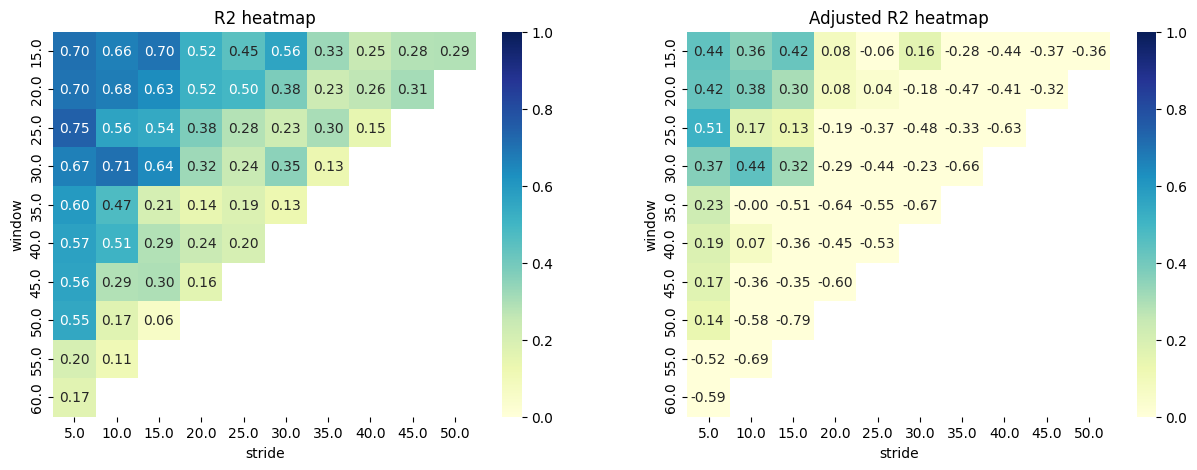

In [91]:
res = window_stride_grid_search_attack(range(15, 65, 5), range(5, 65, 5), AGG_COLS, 'slagarm_hoek_score', 60)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 10/10 [04:38<00:00, 27.89s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

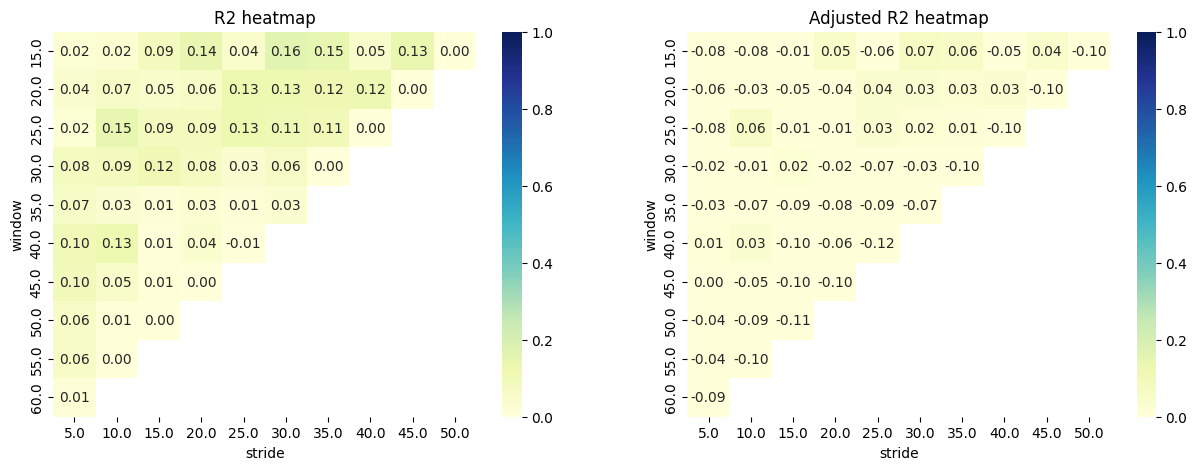

In [92]:
res = window_stride_grid_search_attack(range(15, 65, 5), range(5, 65, 5), ['ra_min', 'ra_max', 'ra_mean', 'ra_std'], 'slagarm_hoek_score', 60)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 10/10 [04:52<00:00, 29.29s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

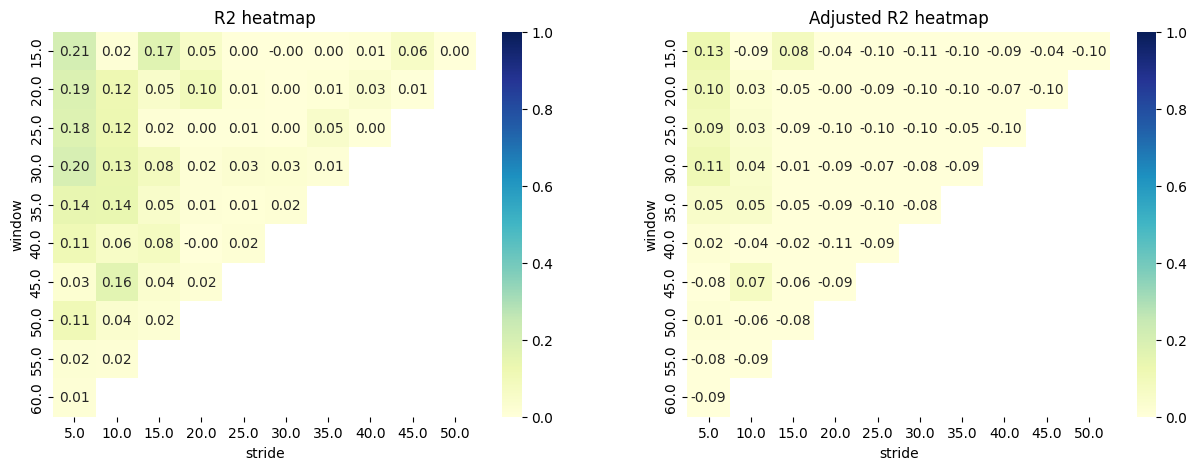

In [101]:
res = window_stride_grid_search_attack(range(15, 65, 5), range(5, 65, 5), ['la_min', 'la_max', 'la_mean', 'la_std'], 'slagarm_hoek_score', 60)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 10/10 [05:25<00:00, 32.58s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

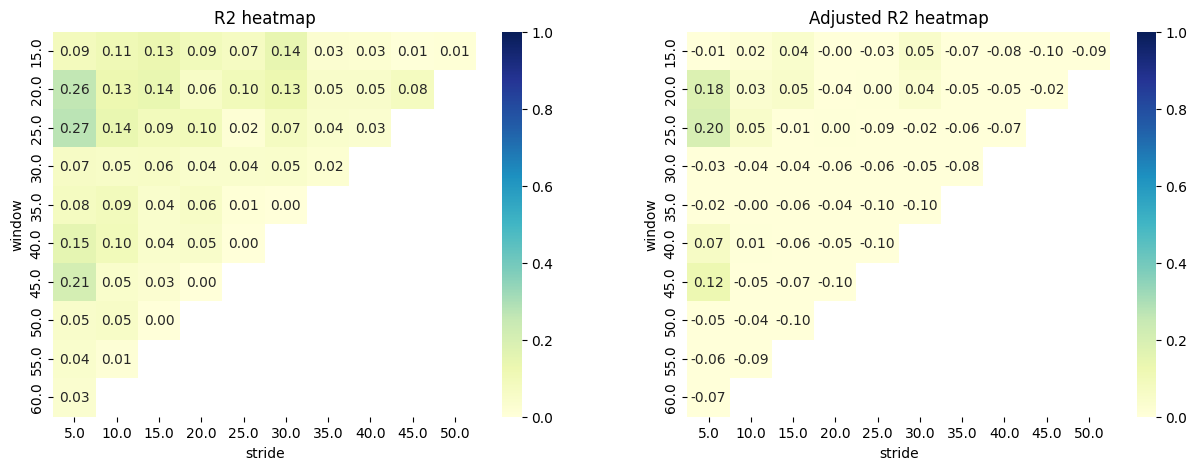

In [102]:
res = window_stride_grid_search_attack(range(15, 65, 5), range(5, 65, 5), ['rl_min', 'rl_max', 'rl_mean', 'rl_std'], 'slagarm_hoek_score', 60)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 10/10 [04:34<00:00, 27.48s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

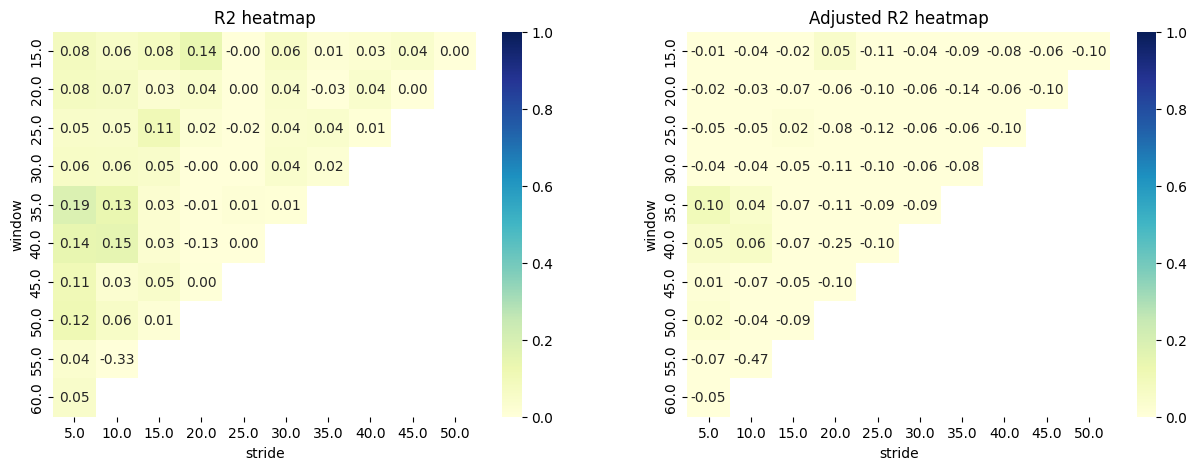

In [103]:
res = window_stride_grid_search_attack(range(15, 65, 5), range(5, 65, 5), ['ll_min', 'll_max', 'll_mean', 'll_std'], 'slagarm_hoek_score', 60)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 10/10 [04:33<00:00, 27.40s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

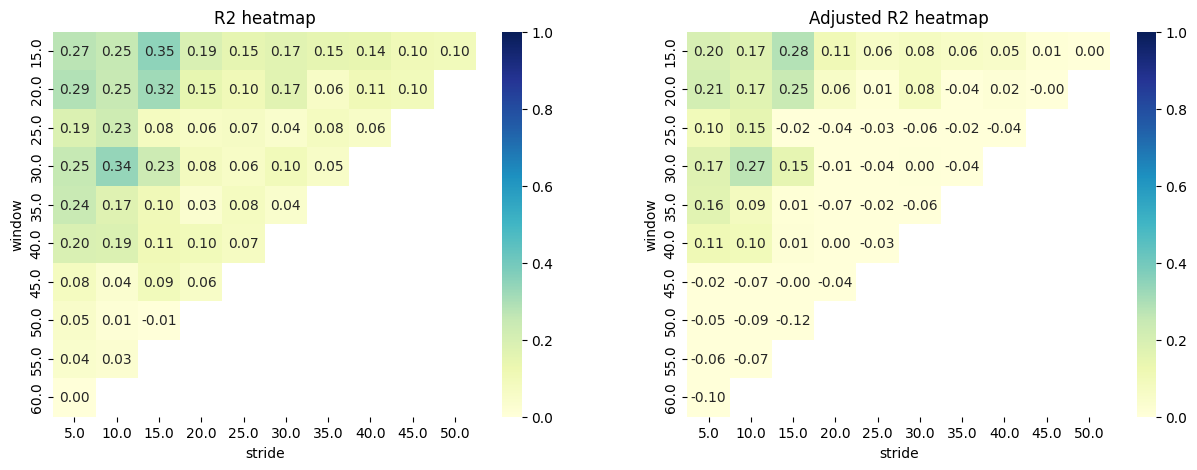

In [104]:
res = window_stride_grid_search_attack(range(15, 65, 5), range(5, 65, 5), ['torso_min', 'torso_max', 'torso_mean', 'torso_std'], 'slagarm_hoek_score', 60)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

## Grid search window, stride for attack as 40 frames around ball hit

100%|██████████| 6/6 [02:02<00:00, 20.34s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

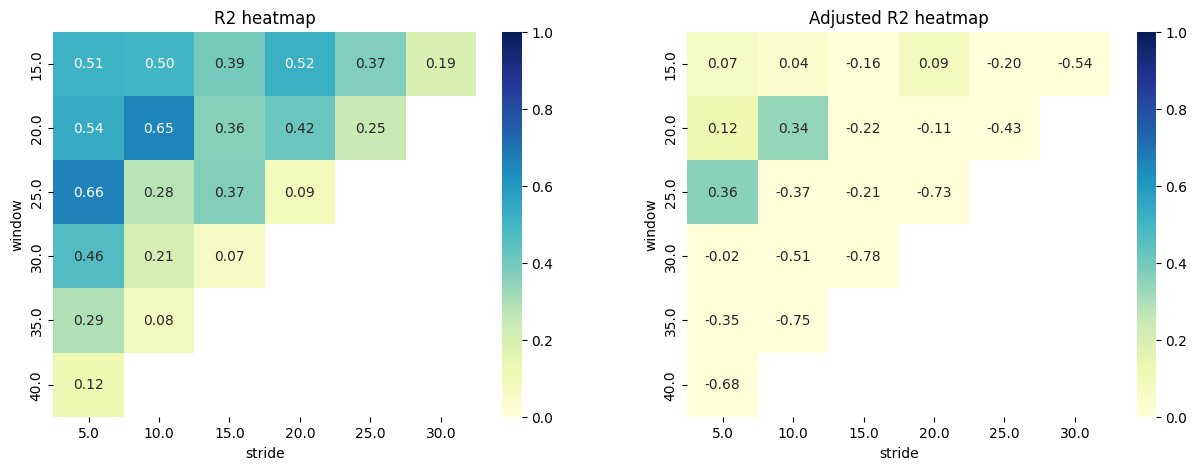

In [93]:
res = window_stride_grid_search_attack(range(15, 45, 5), range(5, 45, 5), AGG_COLS, 'slagarm_hoek_score', 40)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 6/6 [02:06<00:00, 21.08s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

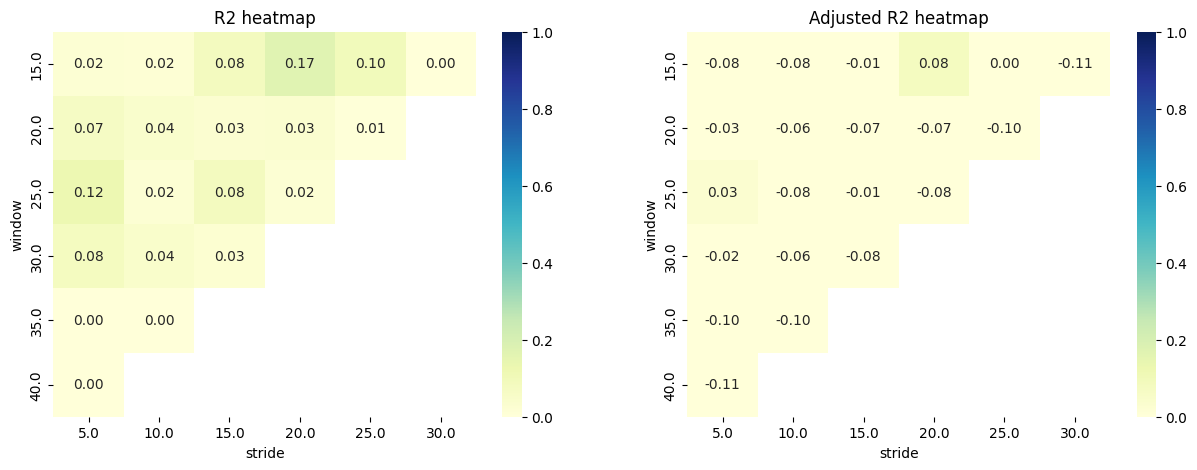

In [94]:
res = window_stride_grid_search_attack(range(15, 45, 5), range(5, 45, 5), ['ra_min', 'ra_max', 'ra_mean', 'ra_std'], 'slagarm_hoek_score', 40)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 6/6 [02:02<00:00, 20.35s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

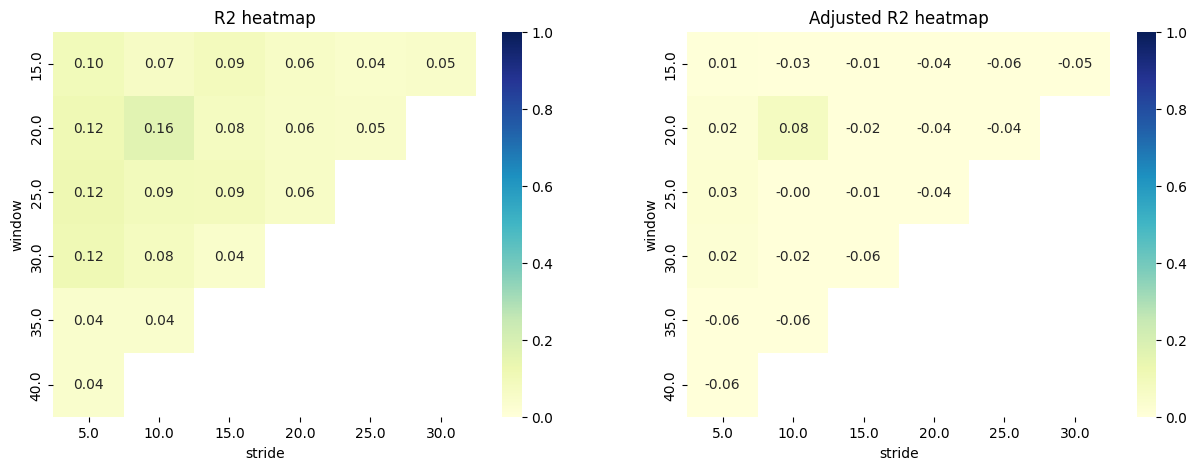

In [105]:
res = window_stride_grid_search_attack(range(15, 45, 5), range(5, 45, 5), ['la_min', 'la_max', 'la_mean', 'la_std'], 'slagarm_hoek_score', 40)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 6/6 [02:24<00:00, 24.15s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

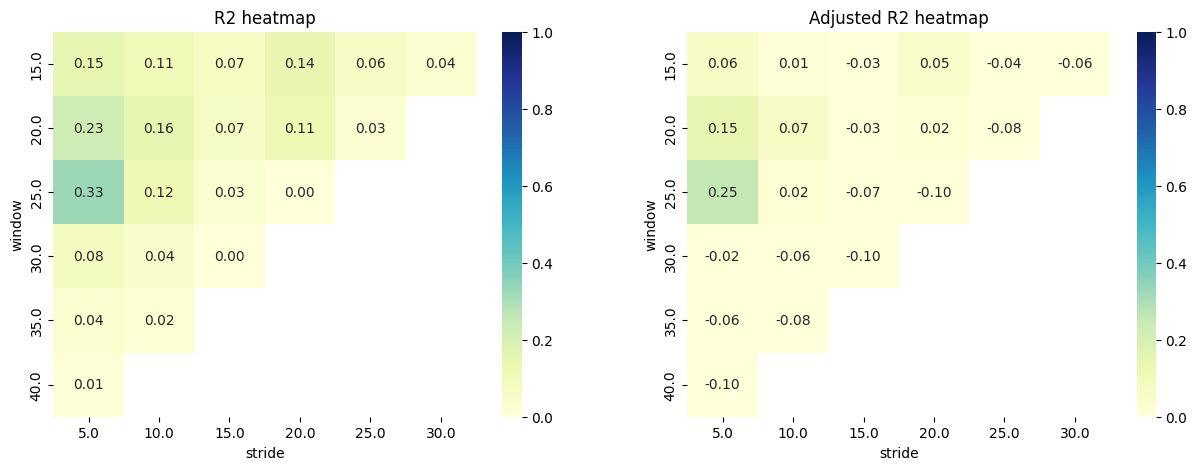

In [106]:
res = window_stride_grid_search_attack(range(15, 45, 5), range(5, 45, 5), ['rl_min', 'rl_max', 'rl_mean', 'rl_std'], 'slagarm_hoek_score', 40)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 6/6 [02:17<00:00, 22.85s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

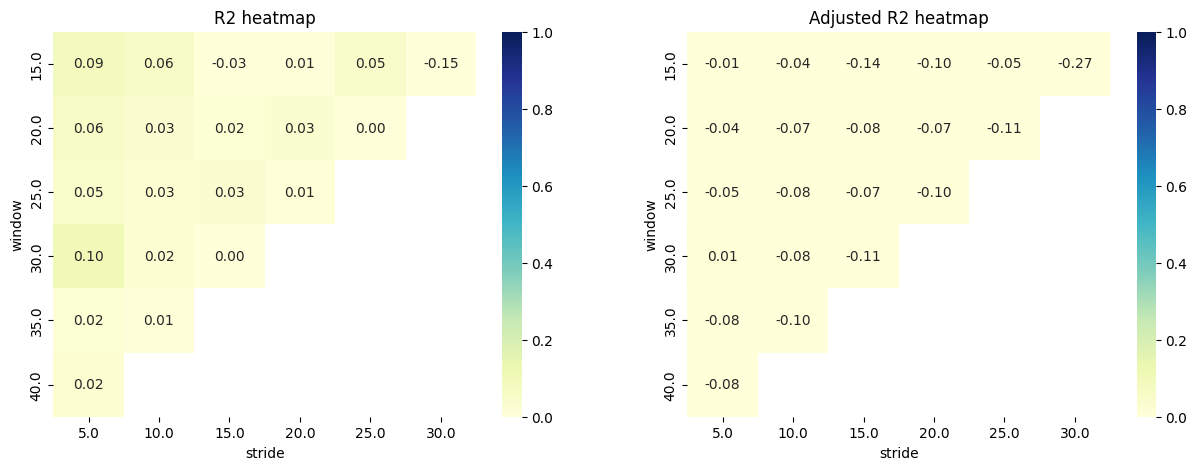

In [107]:
res = window_stride_grid_search_attack(range(15, 45, 5), range(5, 45, 5), ['ll_min', 'll_max', 'll_mean', 'll_std'], 'slagarm_hoek_score', 40)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 6/6 [02:06<00:00, 21.05s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

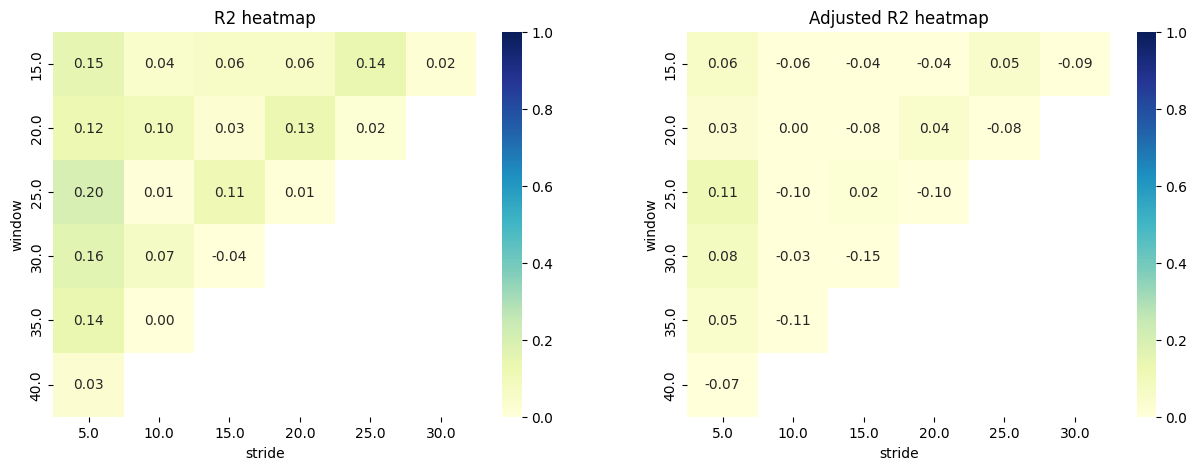

In [108]:
res = window_stride_grid_search_attack(range(15, 45, 5), range(5, 45, 5), ['torso_min', 'torso_max', 'torso_mean', 'torso_std'], 'slagarm_hoek_score', 40)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

## Grid search window, stride for attack as 30 frames around ball hit

100%|██████████| 4/4 [01:07<00:00, 16.76s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

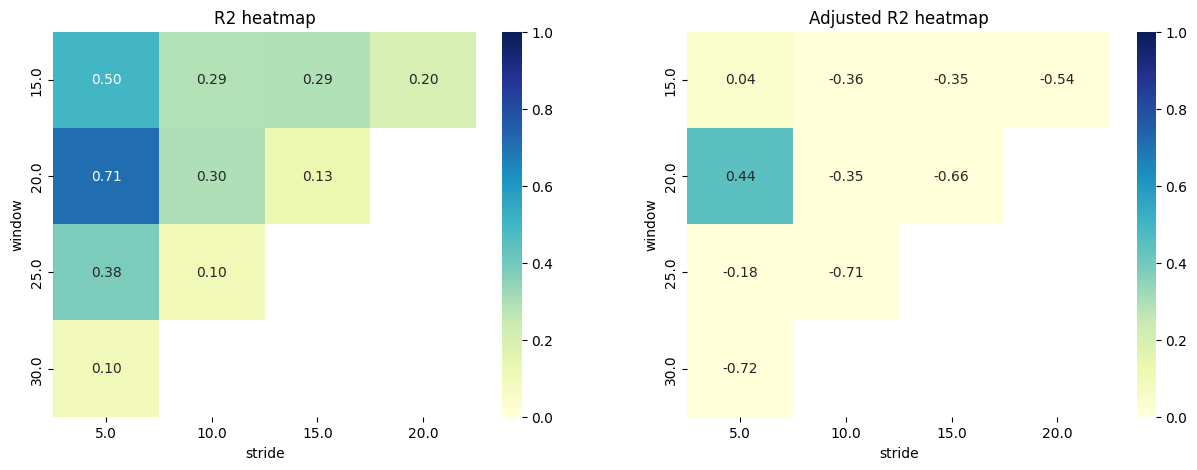

In [95]:
res = window_stride_grid_search_attack(range(15, 35, 5), range(5, 35, 5), AGG_COLS, 'slagarm_hoek_score', 30)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 4/4 [01:05<00:00, 16.41s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

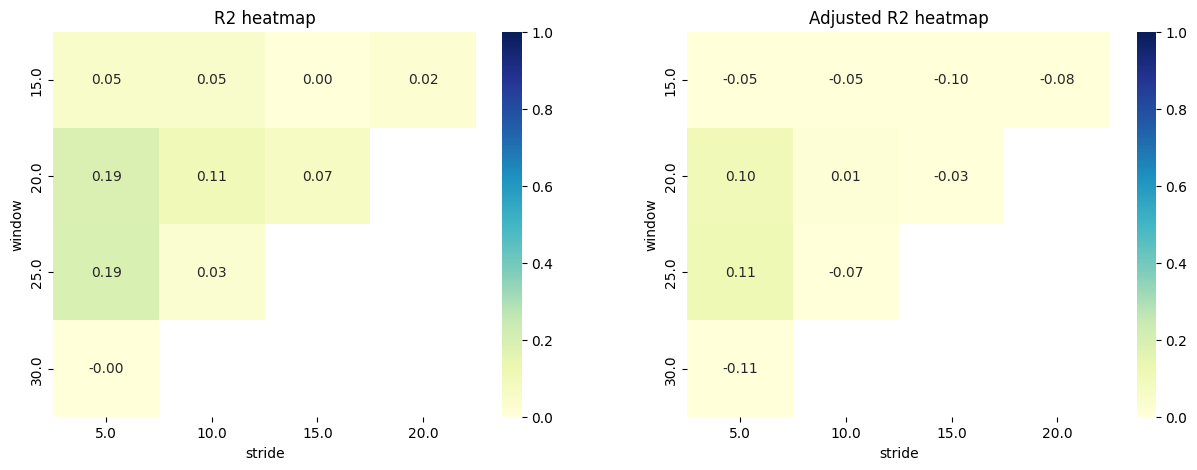

In [96]:
res = window_stride_grid_search_attack(range(15, 35, 5), range(5, 35, 5), ['ra_min', 'ra_max', 'ra_mean', 'ra_std'], 'slagarm_hoek_score', 30)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 4/4 [01:07<00:00, 16.88s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

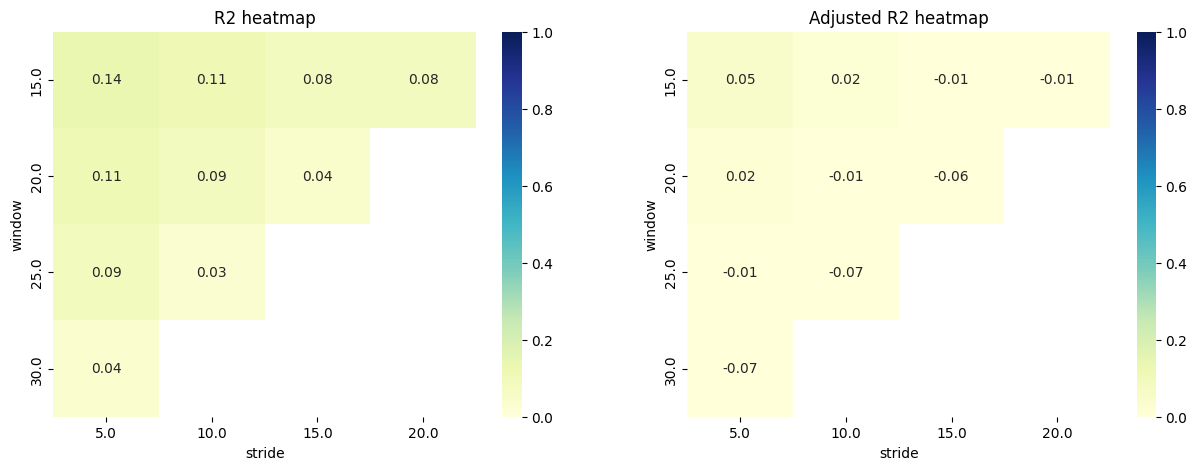

In [97]:
res = window_stride_grid_search_attack(range(15, 35, 5), range(5, 35, 5), ['la_min', 'la_max', 'la_mean', 'la_std'], 'slagarm_hoek_score', 30)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 4/4 [01:07<00:00, 16.98s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

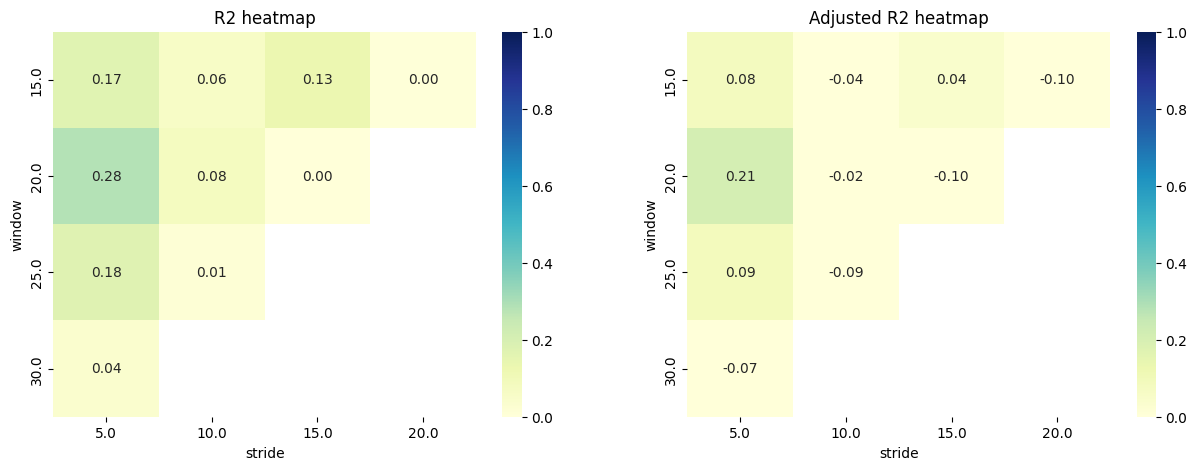

In [98]:
res = window_stride_grid_search_attack(range(15, 35, 5), range(5, 35, 5), ['rl_min', 'rl_max', 'rl_mean', 'rl_std'], 'slagarm_hoek_score', 30)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 4/4 [01:07<00:00, 16.83s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

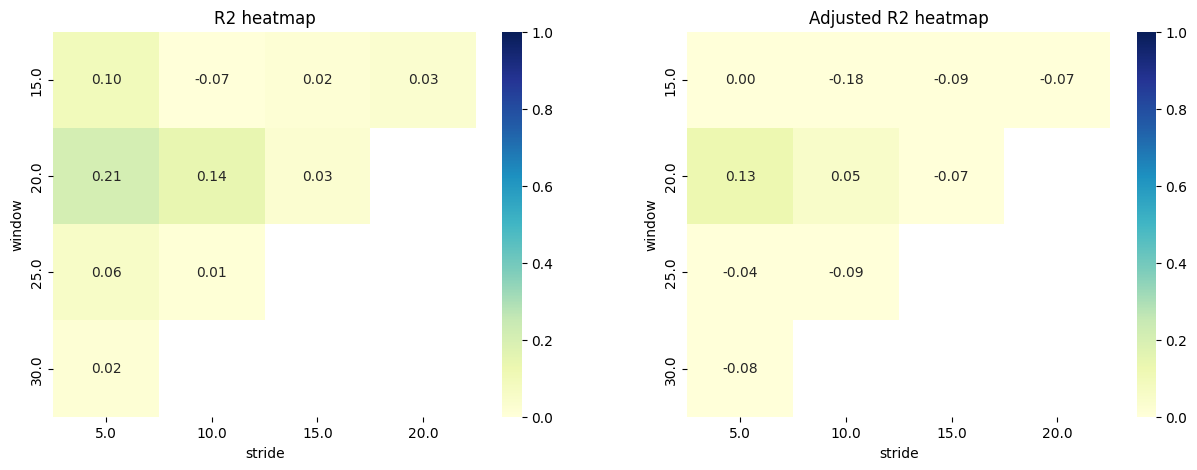

In [99]:
res = window_stride_grid_search_attack(range(15, 35, 5), range(5, 35, 5), ['ll_min', 'll_max', 'll_mean', 'll_std'], 'slagarm_hoek_score', 30)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

100%|██████████| 4/4 [01:07<00:00, 16.90s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

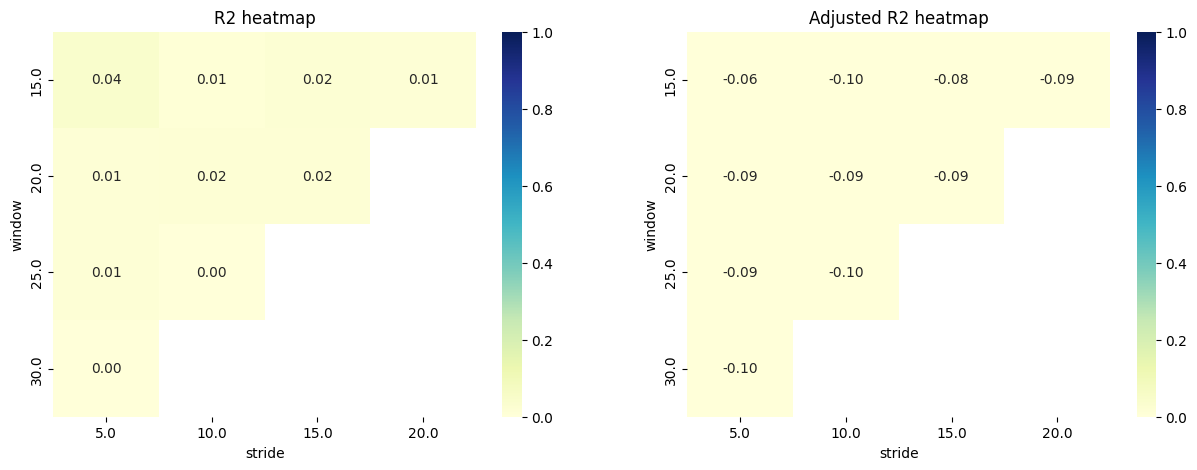

In [100]:
res = window_stride_grid_search_attack(range(15, 35, 5), range(5, 35, 5), ['torso_min', 'torso_max', 'torso_mean', 'torso_std'], 'slagarm_hoek_score', 30)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

## Grid search window, stride for attack as 60 frames around ball hit -- now calculate score for diff not just score

100%|██████████| 10/10 [3:05:21<00:00, 1112.10s/it]  


Text(0.5, 1.0, 'Adjusted R2 heatmap')

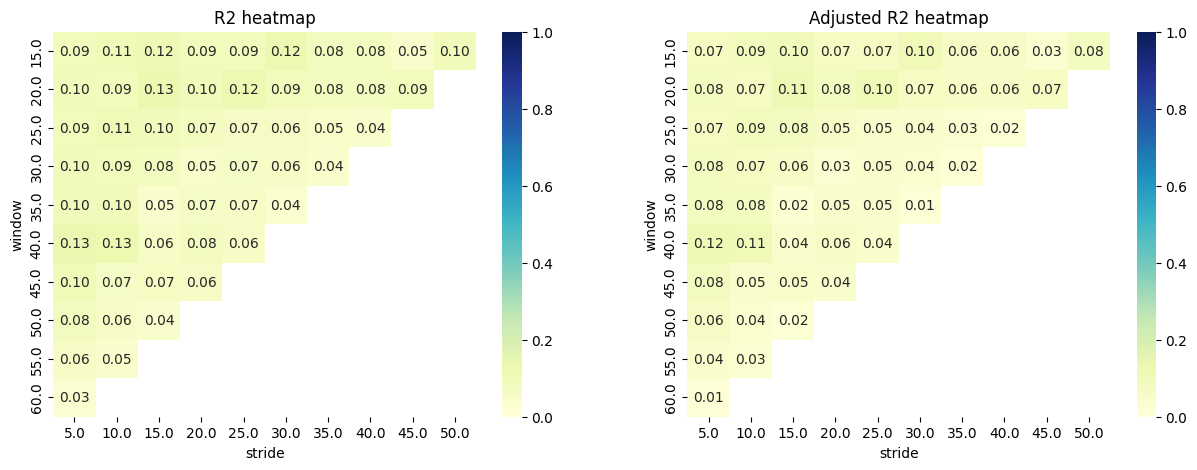

In [11]:
res = window_stride_grid_search_attack_diff(range(15, 65, 5), range(5, 65, 5), AGG_COLS, 'slagarm_hoek_score', 60)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

## Grid search window, stride for attack as 40 frames around ball hit -- now calculate score for diff not just score

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [47:32<00:00, 475.39s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

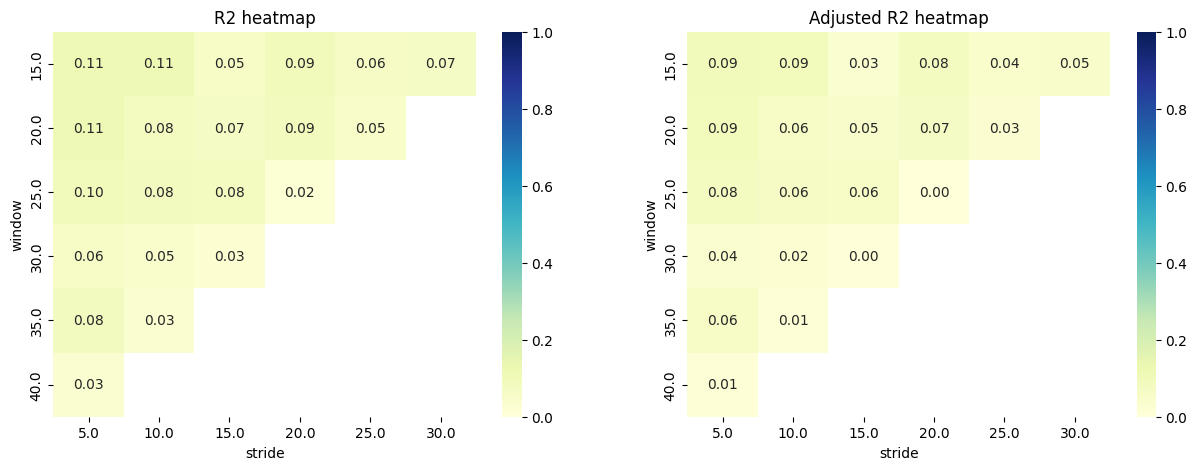

In [10]:
res = window_stride_grid_search_attack_diff(range(15, 45, 5), range(5, 45, 5), AGG_COLS, 'slagarm_hoek_score', 40)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

## Grid search window, stride for attack as 30 frames around ball hit -- now calculate score for diff not just score

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [24:22<00:00, 365.57s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

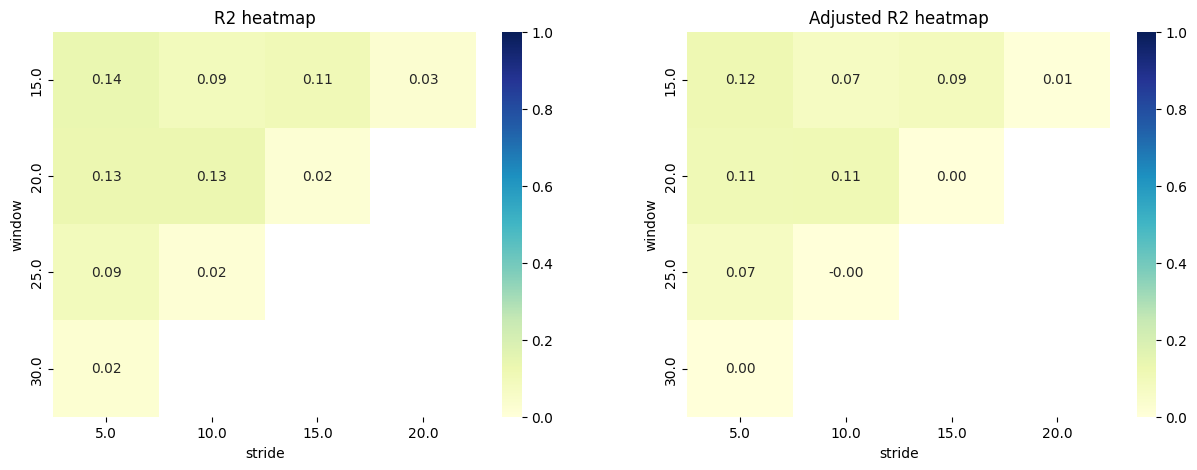

In [10]:
res = window_stride_grid_search_attack_diff(range(15, 35, 5), range(5, 35, 5), AGG_COLS, 'slagarm_hoek_score', 30)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')